# Comparision of all factors used in VQE class given by qiskit on ideal QC

In [1]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

from qiskit.providers.aer import noise
provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [5]:
#Classically solve for the lowest eigenvalue
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

In [6]:
backend = BasicAer.get_backend('statevector_simulator')

In [495]:
# Classically solve for the lowest eigenvalue
# This is used just to compare how well you VQE approximation is performing
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type,threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)

    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction,energy_shift,molecule.nuclear_repulsion_energy

qubitOp, num_spin_orbitals, num_particles, qubit_reduction,energy_shift,nuclear_repulsion_energy = compute_LiH_qubitOp('parity',1.6)
# Classically solve for the exact solution and use that as your reference value
ref = exact_solver(qubitOp)
print(ref)

HF energy: -8.854072040283643
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.077059745734692
-1.077059745734692


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


# Different Optimization


# 1. Optimizer = COBYLA

In [11]:
optimizer =COBYLA(maxiter=1000)

In [12]:
counts_COBYLA = []
values_COBYLA = []
def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_COBYLA.append(eval_count)
            values_COBYLA.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [13]:
result_COBYLA = algo_result['optimal_value']

In [250]:
print(energy_shift)

-7.796219568771226


In [289]:
values_COBYLA_Error = np.subtract(values_COBYLA,ref)

values_COBYLA_Energy = values_COBYLA+nuclear_repulsion_energy+energy_shift

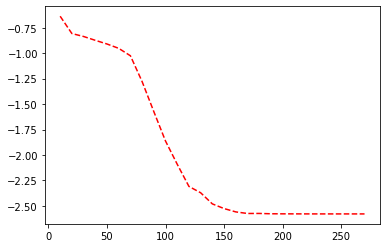

In [290]:
plt.plot(counts_COBYLA,np.log10(values_COBYLA_Error), 'r--')

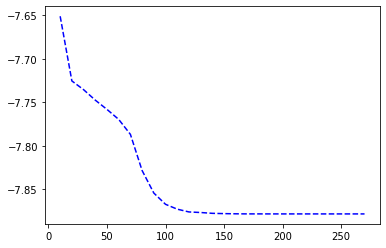

In [291]:
plt.plot(counts_COBYLA,values_COBYLA_Energy, 'b--')

In [18]:
#print(counts_COBYLA ,values_COBYLA)

# 2. Optimizer = L_BFGS_B

In [19]:
optimizer =L_BFGS_B(maxiter=1000)

In [38]:
counts_L_BFGS_B = []
values_L_BFGS_B = []
def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%8 ==0:
            
            counts_L_BFGS_B.append(eval_count)
            values_L_BFGS_B.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
result_L_BFGS_B = algo_result['optimal_value']

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [272]:
print(result_L_BFGS_B)

-0.91957128085456


In [283]:
values_L_BFGS_B_Error = np.subtract(values_L_BFGS_B,ref)


values_L_BFGS_B_Energy = values_L_BFGS_B+energy_shift+nuclear_repulsion_energy

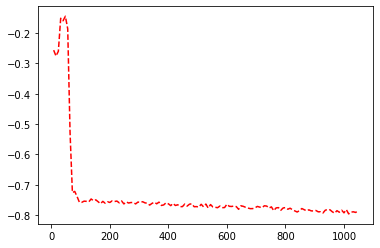

In [284]:
plt.plot(counts_L_BFGS_B,np.log10(values_L_BFGS_B_Error), 'r--')

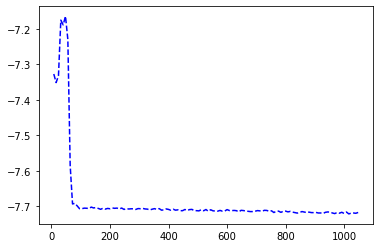

In [292]:
plt.plot(counts_L_BFGS_B,values_L_BFGS_B_Energy, 'b--')

# 3. Optimizer = SLSQP

In [25]:
optimizer =SLSQP(maxiter=1000)

In [26]:
counts_SLSQP = []
values_SLSQP = []
def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_SLSQP.append(eval_count)
            values_SLSQP.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
result_SLSQP = algo_result['optimal_value']

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [27]:
print(result_SLSQP)

-1.07434694582397


In [313]:
values_SLSQP_Error = np.subtract(values_SLSQP,ref)
values_SLSQP_Energy = values_SLSQP+energy_shift+nuclear_repulsion_energy

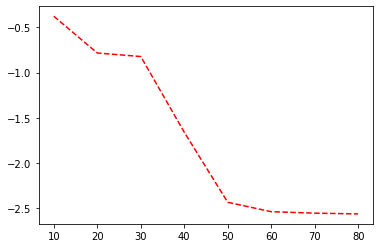

In [314]:
plt.plot(counts_SLSQP,np.log10(values_SLSQP_Error), 'r--')

In [319]:
print(len(counts_SLSQP))
print(len(values_SLSQP_Energy))

8
8


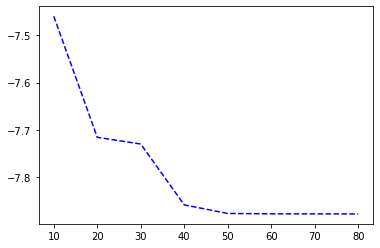

In [318]:
plt.plot(counts_SLSQP,values_SLSQP_Energy, 'b--')

# 4. Optimizer = SPSA

In [31]:
optimizer =SPSA(max_trials=500)

In [32]:
counts_SPSA = []
values_SPSA = []
def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_SPSA.append(eval_count)
            values_SPSA.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
result_SPSA = algo_result['optimal_value']

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [33]:
print(result_SPSA)

-1.07442037084503


In [300]:
values_SPSA_Error = np.subtract(values_SPSA,ref)
values_SPSA_Energy = values_SPSA+energy_shift+nuclear_repulsion_energy

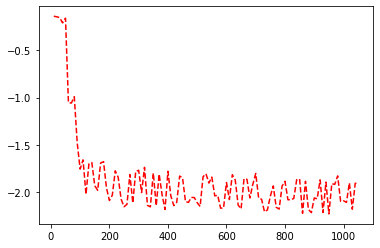

In [301]:
plt.plot(counts_SPSA,np.log10(values_SPSA_Error), 'r--')

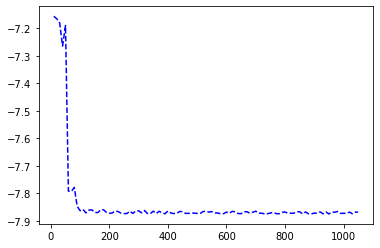

In [302]:
plt.plot(counts_SPSA,values_SPSA_Energy, 'b--')

# Comparision of all Optimizers

1. Eval count v/s log(error)

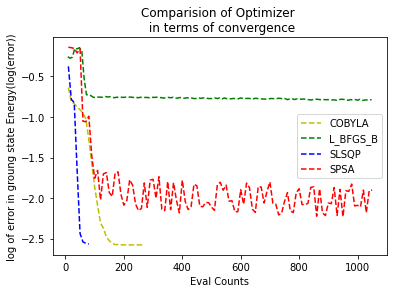

In [320]:
plt.plot(counts_COBYLA,np.log10(values_COBYLA_Error), 'y--',label='COBYLA')
plt.plot(counts_L_BFGS_B,np.log10(values_L_BFGS_B_Error), 'g--',label='L_BFGS_B')
plt.plot(counts_SLSQP,np.log10(values_SLSQP_Error), 'b--',label='SLSQP')
plt.plot(counts_SPSA,np.log10(values_SPSA_Error), 'r--',label='SPSA')
plt.xlabel('Eval Counts')
plt.ylabel('log of error in groung state Energy(log(error))')
plt.title('Comparision of Optimizer \n in terms of convergence')
plt.legend()

2. Eval count v/s error

In [322]:
print(len(counts_SLSQP)==len(values_SLSQP_Energy))

True


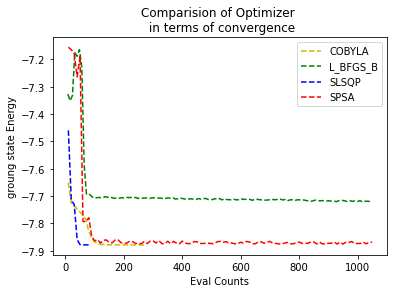

In [323]:
plt.plot(counts_COBYLA,values_COBYLA_Energy, 'y--',label='COBYLA')
plt.plot(counts_L_BFGS_B,values_L_BFGS_B_Energy, 'g--',label='L_BFGS_B')
plt.plot(counts_SLSQP,values_SLSQP_Energy, 'b--',label='SLSQP')
plt.plot(counts_SPSA,values_SPSA_Energy, 'r--',label='SPSA')
plt.xlabel('Eval Counts')
plt.ylabel('groung state Energy')
plt.title('Comparision of Optimizer \n in terms of convergence')
plt.legend()

# Result
Looks like <b>SLSQP</b> is the best Optimizer to be used as it converges <b>Fast</b> as well as has <b>lowest</b> error in all

So we will choose <b>SLSQP</b> from now to get the other factors that works efficiently

# Effect of different Mapping on convergence 
we have parity, bravyi_kitaev, jordan_wigner to check for.

We will also use the time taken by the code to complet as a factor


# 1. Parity

In [223]:
from time import clock

In [224]:
start_Parity= clock()

In [324]:
qubitOp_parity, num_spin_orbitals_parity, num_particles_parity, qubit_reduction_parity,energy_shift_parity,nuclear_repulsion_energy_parity = compute_LiH_qubitOp('parity',1.6)

HF energy: -8.85407204028365
# of electrons: 4
# of spin orbitals: 12


In [226]:
num_qubits = num_spin_orbitals_parity
init_state_parity = Zero(qubitOp.num_qubits)

# Select a state preparation ansatz
# Equivalently, choose a parameterization for our trial wave function.
var_form = UCCSD(
        num_orbitals=num_spin_orbitals_parity,
        num_particles=num_particles_parity,
        initial_state=init_state_parity,
        qubit_mapping='parity')

# Choose where to run/simulate our circuit
quantum_instance = QuantumInstance(backend, shots=1024)

In [227]:
optimizer =SLSQP(maxiter=5000)

In [228]:
counts_Parity = []
values_Parity = []

def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_Parity.append(eval_count)
            values_Parity.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
end_Parity = clock()
result_Parity = algo_result['optimal_value']


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [229]:
ref_parity = exact_solver(qubitOp_parity)
values_parity_Error = np.subtract(values_Parity,ref_parity)

Reference value: -1.0770597457346933


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


In [230]:
Time_Parity = end_Parity - start_Parity
print(Time_Parity )

7.171875


# 2. bravyi_kitaev

In [231]:
start_bravyi_kitaev= clock()

In [325]:
qubitOp_bravyi_kitaev, num_spin_orbitals_bravyi_kitaev, num_particles_bravyi_kitaev, qubit_reduction_bravyi_kitaev,energy_shift_bravyi_kitaev,nuclear_repulsion_energy_bravyi_kitaev = compute_LiH_qubitOp('bravyi_kitaev',1.6)

HF energy: -8.854072040283647
# of electrons: 4
# of spin orbitals: 12


In [233]:
num_qubits = num_spin_orbitals_bravyi_kitaev
init_state_bravyi_kitaev = Zero(qubitOp.num_qubits)

# Select a state preparation ansatz
# Equivalently, choose a parameterization for our trial wave function.
var_form = UCCSD(
        num_orbitals=num_spin_orbitals_bravyi_kitaev,
        num_particles=num_particles_bravyi_kitaev,
        initial_state=init_state_bravyi_kitaev,
        qubit_mapping='bravyi_kitaev')

# Choose where to run/simulate our circuit
quantum_instance = QuantumInstance(backend, shots=1024)

In [234]:
optimizer =SLSQP(maxiter=5000)

In [235]:
counts_bravyi_kitaev = []
values_bravyi_kitaev = []

def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_bravyi_kitaev.append(eval_count)
            values_bravyi_kitaev.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
end_bravyi_kitaev = clock()
result_bravyi_kitaev = algo_result['optimal_value']


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [236]:
Time_bravyi_kitaev = end_bravyi_kitaev - start_bravyi_kitaev
print(Time_bravyi_kitaev )

8.765625


In [237]:
ref_bravyi_kitaev = exact_solver(qubitOp_bravyi_kitaev)
values_bravyi_kitaev_Error = np.subtract(values_bravyi_kitaev,ref_bravyi_kitaev)

Reference value: -1.0770597457346933


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


# 3.   jordan_wigner

In [238]:
start_jordan_wigner= clock()

In [326]:
qubitOp_jordan_wigner, num_spin_orbitals_jordan_wigner, num_particles_jordan_wigner, qubit_reduction_jordan_wigner,energy_shift_jordan_wigner,nuclear_repulsion_energy_jordan_wigner = compute_LiH_qubitOp('jordan_wigner',1.6)

HF energy: -8.854072040283643
# of electrons: 4
# of spin orbitals: 12


In [240]:
print(qubitOp_jordan_wigner,qubit_reduction_jordan_wigner)

Representation: paulis, qubits: 6, size: 118 False


In [241]:
num_qubits = num_spin_orbitals_jordan_wigner
init_state_jordan_wigner = Zero(qubitOp.num_qubits)

# Select a state preparation ansatz
# Equivalently, choose a parameterization for our trial wave function.
var_form = UCCSD(
        num_orbitals=num_spin_orbitals_jordan_wigner,
        num_particles=num_particles_jordan_wigner,
        initial_state=init_state_jordan_wigner,
        qubit_mapping='jordan_wigner')

# Choose where to run/simulate our circuit
quantum_instance = QuantumInstance(backend, shots=1024)

In [242]:
optimizer =SLSQP(maxiter=5000)

In [243]:
counts_jordan_wigner = []
values_jordan_wigner = []

def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_jordan_wigner.append(eval_count)
            values_jordan_wigner.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
end_jordan_wigner = clock()
result_jordan_wigner = algo_result['optimal_value']

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [244]:
Time_jordan_wigner = end_jordan_wigner - start_jordan_wigner
print(Time_jordan_wigner )

5.9375


In [245]:
ref_jordan_wigner = exact_solver(qubitOp_jordan_wigner)
values_jordan_wigner_Error = np.subtract(values_jordan_wigner,ref_jordan_wigner)

Reference value: -1.0770597457346929


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


# Result

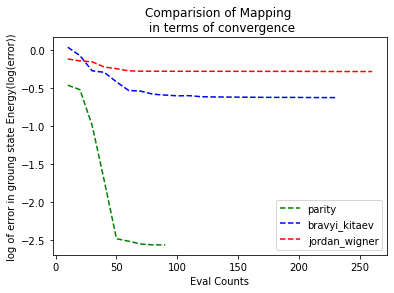

In [246]:
plt.plot(counts_Parity,np.log10(values_parity_Error), 'g--',label='parity')
plt.plot(counts_bravyi_kitaev,np.log10(values_bravyi_kitaev_Error), 'b--',label='bravyi_kitaev')
plt.plot(counts_jordan_wigner,np.log10(values_jordan_wigner_Error), 'r--',label='jordan_wigner')
plt.xlabel('Eval Counts')
plt.ylabel('log of error in groung state Energy(log(error))')
plt.title('Comparision of Mapping \n in terms of convergence')
plt.legend()

In [327]:
values_Parity_energy = values_Parity+nuclear_repulsion_energy_parity+energy_shift_parity
values_bravyi_kitaev_energy = values_bravyi_kitaev+nuclear_repulsion_energy_bravyi_kitaev+energy_shift_bravyi_kitaev
values_jordan_wigner_energy = values_jordan_wigner+nuclear_repulsion_energy_jordan_wigner+energy_shift_jordan_wigner

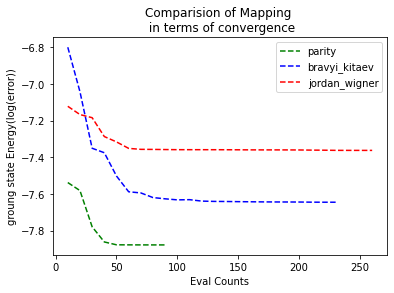

In [328]:
plt.plot(counts_Parity,values_Parity_energy, 'g--',label='parity')
plt.plot(counts_bravyi_kitaev,values_bravyi_kitaev_energy, 'b--',label='bravyi_kitaev')
plt.plot(counts_jordan_wigner,values_jordan_wigner_energy, 'r--',label='jordan_wigner')
plt.xlabel('Eval Counts')
plt.ylabel('groung state Energy(log(error))')
plt.title('Comparision of Mapping \n in terms of convergence')
plt.legend()

In [331]:
print('Time for Parity : ',Time_Parity)
print('Time for Bravyi Kitaev : ',Time_bravyi_kitaev)
print('Time for Jordan Wigner : ',Time_jordan_wigner)

Time for Parity :  7.171875
Time for Bravyi Kitaev :  8.765625
Time for Jordan Wigner :  5.9375


<b>Parity </b> has the best convergence and it also acts on only 4 qubits, while other take 6 qubits. And all of them have comparable speed.

So we will be going with <b>Parity Mapping</b> from here.

# Effect of different  Parameterized circuit on convergence

We have 2 factors assigned allready

1. Optimizer has been taken to be SLSQP
2. Mapping has been taken to be parity

In [381]:
qubitOp, num_spin_orbitals, num_particles, qubit_reduction,energy_shift,nuclear_repulsion_energy = compute_LiH_qubitOp('parity',1.6)

HF energy: -8.854072040283647
# of electrons: 4
# of spin orbitals: 12


In [382]:
optimizer =SLSQP(maxiter=5000)

In [383]:
print(num_spin_orbitals)

6


In [389]:
ref = exact_solver(qubitOp)
num_qubits = 4
init_state = init_state = Zero(qubitOp.num_qubits)

Reference value: -1.0770597457346962


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


# 1. UCCSD

In [390]:
# Select a state preparation ansatz
# Equivalently, choose a parameterization for our trial wave function.
var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=init_state,
        qubit_mapping='parity'
    )

# Choose where to run/simulate our circuit
quantum_instance = QuantumInstance(backend, shots=1024)

In [391]:
counts_UCCSD = []
values_UCCSD = []

def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_UCCSD.append(eval_count)
            values_UCCSD.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
result_UCCSD = algo_result['optimal_value']

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [392]:
print(result_UCCSD+energy_shift+nuclear_repulsion_energy)

-7.878412108557947


In [393]:
values_UCCSD_error = (values_UCCSD-ref)
values_UCCSD_Energy = (values_UCCSD+energy_shift+nuclear_repulsion_energy)

# 2. Ry

In [403]:
var_form = RY(num_qubits)
quantum_instance = QuantumInstance(backend, shots=1024)

/home/codie/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  """Entry point for launching an IPython kernel.


In [447]:
counts_ry = []
values_ry = []

def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_ry.append(eval_count)
            values_ry.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
result_ry = algo_result['optimal_value']

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [448]:
print(result_ry+energy_shift+nuclear_repulsion_energy)

-7.867011527422666


In [406]:
values_ry_error = (values_ry-ref)
values_ry_Energy = (values_ry+energy_shift+nuclear_repulsion_energy)

# 3. RYRZ

In [427]:
var_form = RYRZ(num_qubits)
quantum_instance = QuantumInstance(backend, shots=1024)

/home/codie/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  """Entry point for launching an IPython kernel.


In [444]:
counts_ryrz = []
values_ryrz = []

def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_ryrz.append(eval_count)
            values_ryrz.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
result_ryrz = algo_result['optimal_value']

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [445]:
print(result_ryrz+energy_shift+nuclear_repulsion_energy)

-7.880881889628076


In [446]:
values_ryrz_error = (values_ryrz-ref)
values_ryrz_Energy = (values_ryrz+energy_shift+nuclear_repulsion_energy)

In [443]:
#print(len(values_ryrz_error))
#print(values_ryrz_Energy)

In [483]:
#plt.plot(counts_ryrz,values_ryrz_Energy)

# 4. SwapRZ

In [413]:
var_form = SwapRZ(num_qubits)
quantum_instance = QuantumInstance(backend, shots=1024)

/home/codie/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The qiskit.aqua.components.variational_forms.SwapRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use the qiskit.circuit.library.ExcitationPreserving object instead.
  """Entry point for launching an IPython kernel.


In [420]:
counts_SwapRZ = []
values_SwapRZ = []

def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_SwapRZ.append(eval_count)
            values_SwapRZ.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
result_SwapRZ = algo_result['optimal_value']

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [421]:
print(result_SwapRZ+energy_shift+nuclear_repulsion_energy)

-7.358803586453367


In [422]:
values_SwapRZ_error = (values_SwapRZ-ref)
values_SwapRZ_Energy = (values_SwapRZ+energy_shift+nuclear_repulsion_energy)

In [438]:
print(values_SwapRZ_Energy)

[-7.35880359 -7.35880359 -7.35880359]


# Result

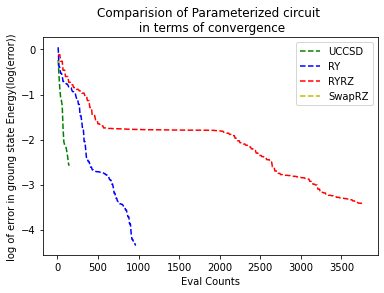

In [436]:
plt.plot(counts_UCCSD,np.log10(values_UCCSD_error), 'g--',label='UCCSD')
plt.plot(counts_ry,np.log10(values_ry_error), 'b--',label='RY')
plt.plot(counts_ryrz,np.log10(values_ryrz_error), 'r--',label='RYRZ')
plt.plot(counts_SwapRZ,np.log10(values_SwapRZ_error), 'y--',label='SwapRZ')
plt.xlabel('Eval Counts')
plt.ylabel('log of error in groung state Energy(log(error))')
plt.title('Comparision of Parameterized circuit \n in terms of convergence')
plt.legend()

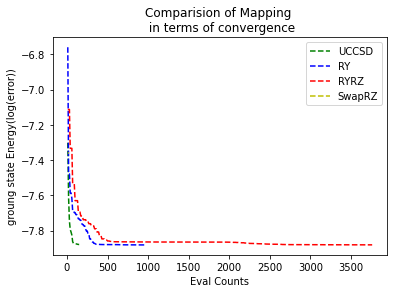

In [442]:
plt.plot(counts_UCCSD,(values_UCCSD_Energy), 'g--',label='UCCSD')
plt.plot(counts_ry,(values_ry_Energy), 'b--',label='RY')
plt.plot(counts_ryrz,(values_ryrz_Energy), 'r--',label='RYRZ')
plt.plot(counts_SwapRZ,(values_SwapRZ_Energy), 'y--',label='SwapRZ')
plt.xlabel('Eval Counts')
plt.ylabel('groung state Energy(log(error))')
plt.title('Comparision of Mapping \n in terms of convergence')
plt.legend()

We have 3 observation here
1. UCCSD converges rapidly
2. RY takes some time but gives omparable result as the UCCSD, we can say slitely better in this case. But when used multiple times the ground state energy varries from -7.86 to -7.88 so its not a good choice to make
3. RYRZ converges to the best result of all but takes too much of steps and time.

So we will stick to <b>UCCSD</b> for now.

#  Effect of different Initial state on convergence

In [449]:
qubitOp, num_spin_orbitals, num_particles, qubit_reduction,energy_shift,nuclear_repulsion_energy = compute_LiH_qubitOp('parity',1.6)

HF energy: -8.854072040283643
# of electrons: 4
# of spin orbitals: 12


In [450]:
optimizer =SLSQP(maxiter=5000)

In [451]:
ref = exact_solver(qubitOp)
num_qubits = 4


Reference value: -1.0770597457346958


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


# 1. Zero(qubitOp.num_qubits)

In [457]:
init_state = Zero(qubitOp.num_qubits)

In [461]:
# Select a state preparation ansatz
# Equivalently, choose a parameterization for our trial wave function.
var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=init_state,
        qubit_mapping='parity'
    )

# Choose where to run/simulate our circuit
quantum_instance = QuantumInstance(backend, shots=1024)

counts_zero = []
values_zero = []

def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_zero.append(eval_count)
            values_zero.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
result_zero = algo_result['optimal_value']

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [462]:
print(result_zero+energy_shift+nuclear_repulsion_energy)

-7.880916046355732


In [463]:
values_zero_error = (values_zero-ref)
values_zero_Energy = (values_zero+energy_shift+nuclear_repulsion_energy)

# 2. HartreeFock

In [475]:
initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity',two_qubit_reduction=qubit_reduction)

In [476]:
# Select a state preparation ansatz
# Equivalently, choose a parameterization for our trial wave function.
var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=init_state,
        qubit_mapping='parity'
    )

# Choose where to run/simulate our circuit
quantum_instance = QuantumInstance(backend, shots=1024)

counts_HartreeFock = []
values_HartreeFock = []

def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count%10 ==0:
            
            counts_HartreeFock.append(eval_count)
            values_HartreeFock.append(mean)

algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

algo_result = algo.run(quantum_instance)
result_HartreeFock = algo_result['optimal_value']

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

In [477]:
print(result_HartreeFock+energy_shift+nuclear_repulsion_energy)

-7.87834470198096


In [478]:
values_HartreeFock_error = (values_HartreeFock-ref)
values_HartreeFock_Energy = (values_HartreeFock+energy_shift+nuclear_repulsion_energy)

# Result

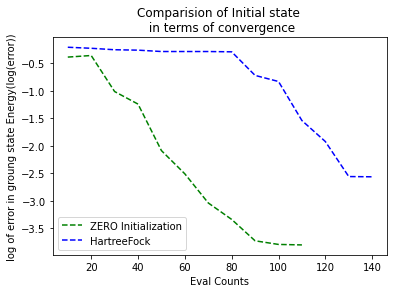

In [480]:
plt.plot(counts_zero,np.log10(values_zero_error), 'g--',label='ZERO Initialization')
plt.plot(counts_HartreeFock,np.log10(values_HartreeFock_error), 'b--',label='HartreeFock')

plt.xlabel('Eval Counts')
plt.ylabel('log of error in groung state Energy(log(error))')
plt.title('Comparision of Initial state \n in terms of convergence')
plt.legend()

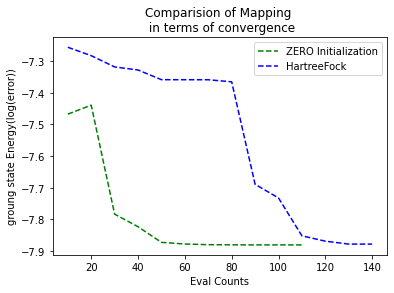

In [482]:
plt.plot(counts_zero,(values_zero_Energy), 'g--',label='ZERO Initialization')
plt.plot(counts_HartreeFock,(values_HartreeFock_Energy), 'b--',label='HartreeFock')
plt.xlabel('Eval Counts')
plt.ylabel('groung state Energy(log(error))')
plt.title('Comparision of Mapping \n in terms of convergence')
plt.legend()

<b>Zero Initializarion</b> converges multiple times fast as conpared to the HartreeFock initialization

# End Result 
1. Mapping as <b> Parity</b>
2. Initialization as <b>Zero Initialization</b>
3. Parameterized circuit as <b>UCCSD</b>
4. Optimizer as <b>SLSQP</b>

# Making ground state Energy graph

In [517]:
distances = np.arange(0.5, 4.0, 0.1)

In [518]:
optimizer = SLSQP(maxiter=5000)

In [519]:
exact_energies = []
vqe_energies = []
for dist in distances:
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction,energy_shift,nuclear_repulsion_energy = compute_LiH_qubitOp('parity',dist)
    result = exact_solver(qubitOp)
    exact_energies.append(result + energy_shift+nuclear_repulsion_energy)
    init_state = Zero(qubitOp.num_qubits)
    #initial_state = HartreeFock(
    #    num_spin_orbitals,
    #    num_particles,
    #    qubit_mapping='parity',two_qubit_reduction=qubit_reduction)
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=init_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + energy_shift+nuclear_repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
print("All energies have been calculated")


HF energy: -10.203473360061935
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.9792675459817671


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)


Interatomic Distance: 0.5 VQE Result: -7.037863357345961 Exact Energy: -7.039732521635198
HF energy: -9.945427105942244
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0492360352400558


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 0.6 VQE Result: -7.311958047810299 Exact Energy: -7.313345828761003
HF energy: -9.753847203061563
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.1072409268515326


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 0.7 VQE Result: -7.402179688784489 Exact Energy: -7.500922090905933
HF energy: -9.6001847021821
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.146159486057083


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 0.8 VQE Result: -7.629537508671568 Exact Energy: -7.630978249333211
HF energy: -9.469677376536115
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.1666529075459404


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 0.9 VQE Result: -7.719330872854796 Exact Energy: -7.7208124121347765
HF energy: -9.35489376850856
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.1724576315066801


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 1.0 VQE Result: -7.649312733696688 Exact Energy: -7.782242402637007
HF energy: -9.25195375172978
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.1677496984795812


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)


Interatomic Distance: 1.1 VQE Result: -7.821893605505421 Exact Energy: -7.8235992763628115
HF energy: -9.158558852856917
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.155948370908334


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 1.2 VQE Result: -7.7087577580083675 Exact Energy: -7.8506983775960215
HF energy: -9.07313203700239
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.1395170562731232


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 1.3 VQE Result: -7.865659226612488 Exact Energy: -7.86756329011005
HF energy: -8.994489827277835
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.1201611749420295


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 1.4 VQE Result: -7.742576349339849 Exact Energy: -7.877001491818369
HF energy: -8.921712043375118
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0990640886979144


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 1.5 VQE Result: -7.8786200444824495 Exact Energy: -7.881015715646994
HF energy: -8.854072040283647
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.07705974573469


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 1.6 VQE Result: -7.878434791222769 Exact Energy: -7.881072044030918
HF energy: -8.790987097121473
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0547453451691498


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)


Interatomic Distance: 1.7 VQE Result: -7.87522297622362 Exact Energy: -7.8782681675849915
HF energy: -8.731980715366806
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0325546279316755


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 1.8 VQE Result: -7.869880246094229 Exact Energy: -7.873440293132824
HF energy: -8.676655005381932
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0108065711594654


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 1.9 VQE Result: -7.862926621043876 Exact Energy: -7.86723396481603
HF energy: -8.624671401017078
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.9897385289532651


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 2.0 VQE Result: -7.8551108153371025 Exact Energy: -7.860153207378778
HF energy: -8.575737701949144
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.9695292622057857


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 2.1 VQE Result: -7.8465171020631495 Exact Energy: -7.852595827876735
HF energy: -8.529599656891158
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.9503150161697725


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)


Interatomic Distance: 2.2 VQE Result: -7.841461248024746 Exact Energy: -7.844879093009718
HF energy: -8.486035628495895
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.9322002310160723


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 2.3 VQE Result: -7.82822440335222 Exact Energy: -7.837257967615502
HF energy: -8.444853140805392
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.9152635250120866


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 2.4 VQE Result: -7.811950784830578 Exact Energy: -7.829937002623395
HF energy: -8.405886322325905
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.8995593552808273


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 2.5 VQE Result: -7.8095863824851355 Exact Energy: -7.823076642134093
HF energy: -8.368993488572691
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.885116268239299


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 2.6 VQE Result: -7.800340410020044 Exact Energy: -7.816795150472934
HF energy: -8.334054386160982
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.8719336452099806


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 2.7 VQE Result: -7.791318509613811 Exact Energy: -7.811168284803362
HF energy: -8.300966923295366
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.8599796249069968


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 2.8 VQE Result: -7.782592342647344 Exact Energy: -7.806229560089849
HF energy: -8.269643484101085
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.849192573619749


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 2.9 VQE Result: -7.757146728976711 Exact Energy: -7.8019736023325486
HF energy: -8.24000711113722
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.8394868459556767


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 3.0 VQE Result: -7.781985475851808 Exact Energy: -7.798363430915124
HF energy: -8.211987911097173
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.8307615452177812


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)


Interatomic Distance: 3.1 VQE Result: -7.756989838102177 Exact Energy: -7.795340451637529
HF energy: -8.185519998537496
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.8229098670783407


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 3.2 VQE Result: -7.755694072958779 Exact Energy: -7.792834806738609
HF energy: -8.160539177255497
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.8158269098961479


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 3.3 VQE Result: -7.7434840399915155 Exact Energy: -7.790774009971012
HF energy: -8.136981417970144
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.809414946820474


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 3.4 VQE Result: -7.7886629047661255 Exact Energy: -7.78908889799148
HF energy: -8.114782068018084
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.8035862068185049


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 3.5 VQE Result: -7.7839151796559 Exact Energy: -7.7877169734661456
HF energy: -8.093875649366343
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.7982637662627333


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 3.6 VQE Result: -7.696442375856215 Exact Energy: -7.786603763673838
HF energy: -8.074196070261745
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.7933812533548354


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 3.7 VQE Result: -7.730977960697122 Exact Energy: -7.785702912499928
HF energy: -8.055677083373517
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.7888819285511188


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 3.8 VQE Result: -7.738905456909122 Exact Energy: -7.7849755916983705
HF energy: -8.038252853722309
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.7847175266813549


/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a futur

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/codie/my_env/lib/python3.6/site-packages/qiskit/aqua/operators/state_fns/vector

Interatomic Distance: 3.9 VQE Result: -7.721551303059621 Exact Energy: -7.784389611671785
All energies have been calculated


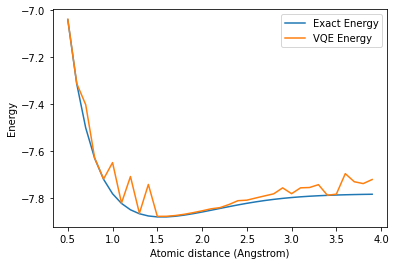

In [520]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()